# Iluka (ILU.AX) analyse

In [2]:
# %load ./_Snippets/finance_import_block.py
# Uncomment lorsque qu'une nouvelle ligne s'ajoute

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)
#from pandas.plotting import register_matplotlib_converters
#register_matplotlib_converters()
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima.model import ARIMA
from yahoofinancials import YahooFinancials)

import warnings
warnings.filterwarnings('ignore')

# Print automatiquement toutes les variables de la cellule (pas juste la dernière)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" #"last_expr" pour rétablir par défaut

%config InlineBackend.figure_format ='retina'

# Package maison
from FinForecast import ArimaForecast as af
from FinForecast import InvestStrat

In [7]:
import cufflinks as cf
from plotly.offline import iplot, init_notebook_mode

In [21]:
#from FinForecast import ArimaForecast as af

## Wrangling

In [3]:
ticker = 'ILU.AX'
yahoo_financials = YahooFinancials(ticker)

data = yahoo_financials.get_historical_price_data(start_date='2014-01-01', 
                                                  end_date='2019-12-31', 
                                                  time_interval='daily')

# Extraire 'price' keys du dict vers un df
ILU = pd.DataFrame(data[ticker]['prices'])

# Remplacer 'formatted_date' col par 'Date'
col = list(ILU.columns) 
col[-1] = 'Date'
ILU.columns = col

# Set index to 'Date'
ILU = ILU.drop('date', axis=1).set_index('Date')

ILU['rtn5'] = ILU['adjclose'].pct_change(5)*100
ILU['rtn5_stdev'], ILU_ravg = af.tfrm_to_MinusMean(ILU['rtn5'])
col_drop = list(ILU.columns[:4])
ILU.drop(columns= col_drop, inplace= True)

ILU_div = pd.DataFrame(data[ticker]['eventsData']['dividends'])
ILU_div = ILU_div.transpose().drop('date', axis=1)

# Remplacer 'formatted_date' par 'Date' et 'amount' par 'Dividends'
ILU_div.columns = ['Dividends', 'Date']
ILU_div.set_index('Date', inplace= True)

# Merge les deux DataFrames
ILU = pd.merge(ILU, ILU_div, left_index= True, right_index= True, how='outer')
ILU.index = pd.to_datetime(ILU.index)

ILU.head()

volume  adjclose  rtn5  rtn5_stdev Dividends
Date                                                     
2014-01-01   990173  7.604320   NaN         NaN       NaN
2014-01-02  1172097  7.595639   NaN         NaN       NaN
2014-01-05  1271133  7.560915   NaN         NaN       NaN
2014-01-06  1394498  7.456748   NaN         NaN       NaN
2014-01-07  1037075  7.448067   NaN         NaN       NaN

In [11]:
#%store ILU

Stored 'ILU' (DataFrame)


In [6]:
who

ARIMA	 ARMA	 ILU	 ILU_2016	 InteractiveShell	 YahooFinancials	 adfuller	 af	 np	 
pd	 plot_acf	 plot_pacf	 plt	 sns	 warnings	 


## EDA

In [2]:
store -r

In [3]:
ILU_2016 = ILU.loc['2016']
ILU_2016

volume  adjclose      rtn5  rtn5_stdev Dividends
Date                                                         
2016-01-03  2363338  5.579931  4.194626   -3.613997       NaN
2016-01-04  1878898  5.490077  2.516777   -5.075905       NaN
2016-01-05  2808710  5.211530 -5.996755  -12.552599       NaN
2016-01-06  1878174  5.049793 -9.208398  -14.706738       NaN
2016-01-07  2113274  5.049793 -8.319732  -12.600859       NaN
...             ...       ...       ...         ...       ...
2016-12-21  1562858  6.514658  1.587307   -1.395561       NaN
2016-12-22  1126152  6.505405  2.478136    0.364465       NaN
2016-12-27   864256  6.616450  4.532149    2.371084       NaN
2016-12-28   941025  6.727496  7.544391    5.236616       NaN
2016-12-29   898545  6.727496  2.683631    1.206745       NaN

[253 rows x 5 columns]

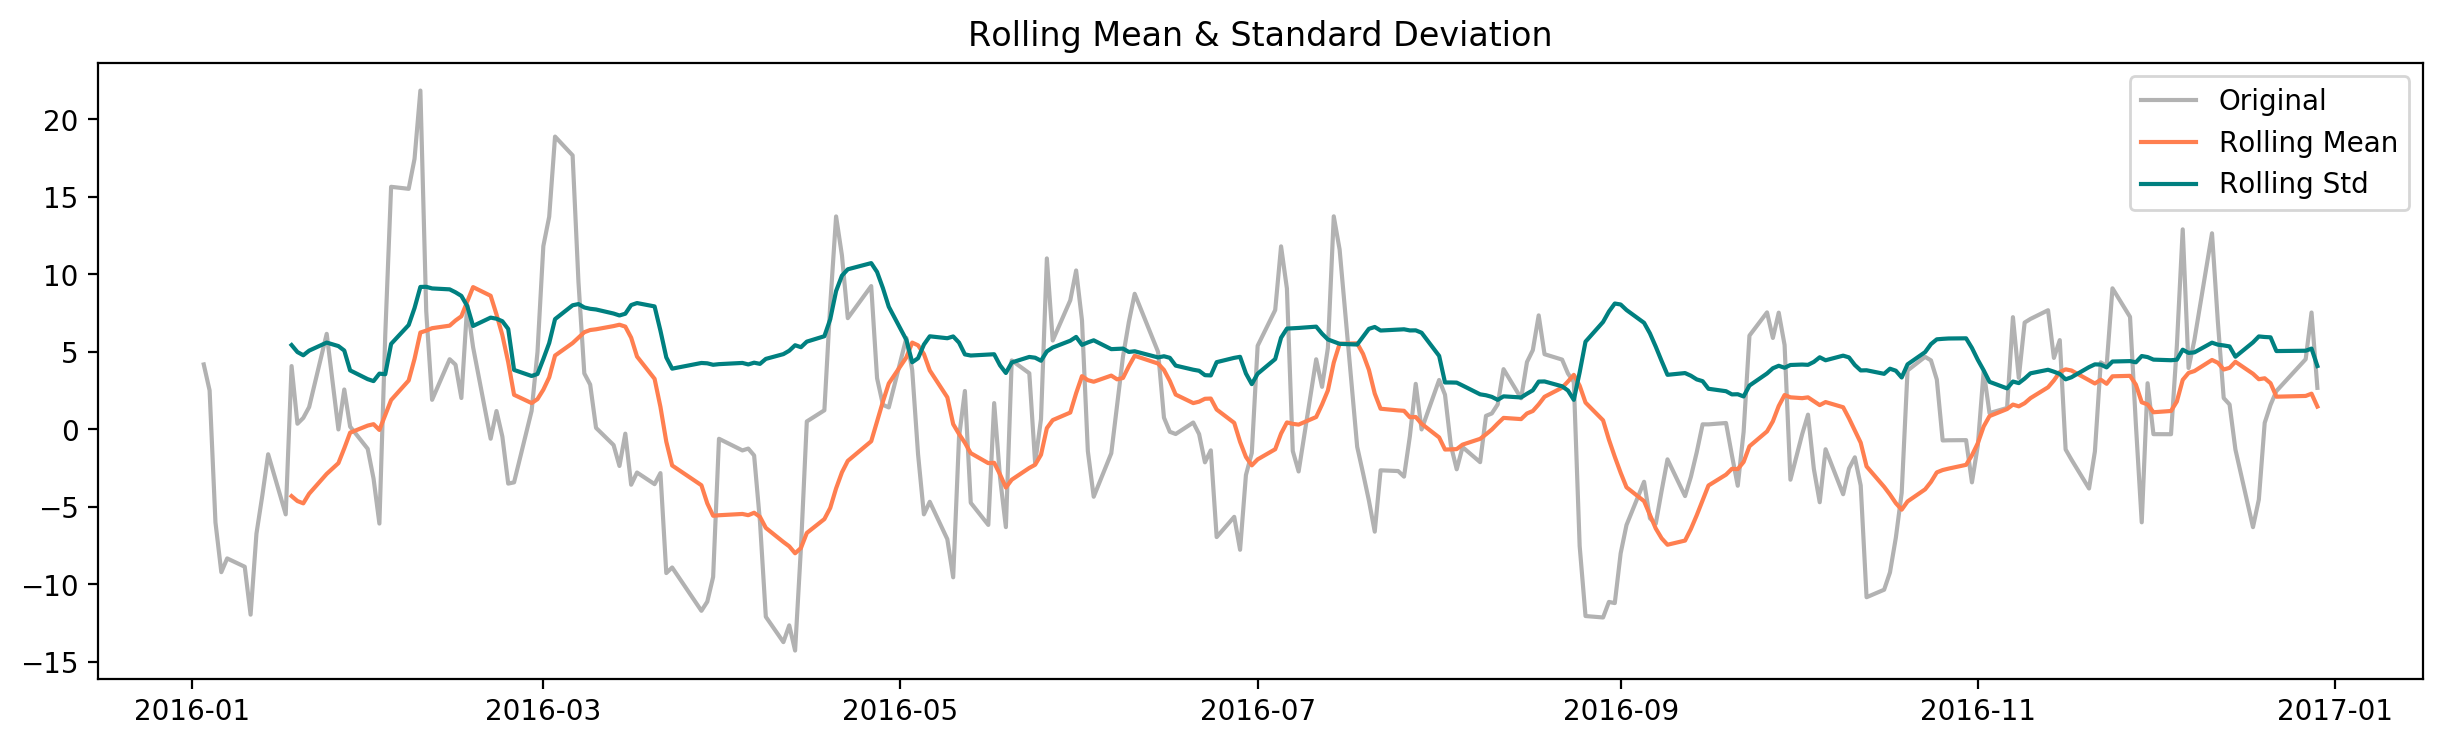

Mean MinMax Delta: 17.169678572829902
Std MinMax Delta: 8.821639815846522
ADF Statistic: -4.423802338533436
p-value: 0.0002693278377566341
Critical Values:
	1%: -3.4577787098622674
	5%: -2.873608704758507
	10%: -2.573201765981991


In [15]:
af.get_stationarity(ILU_2016['rtn5'])

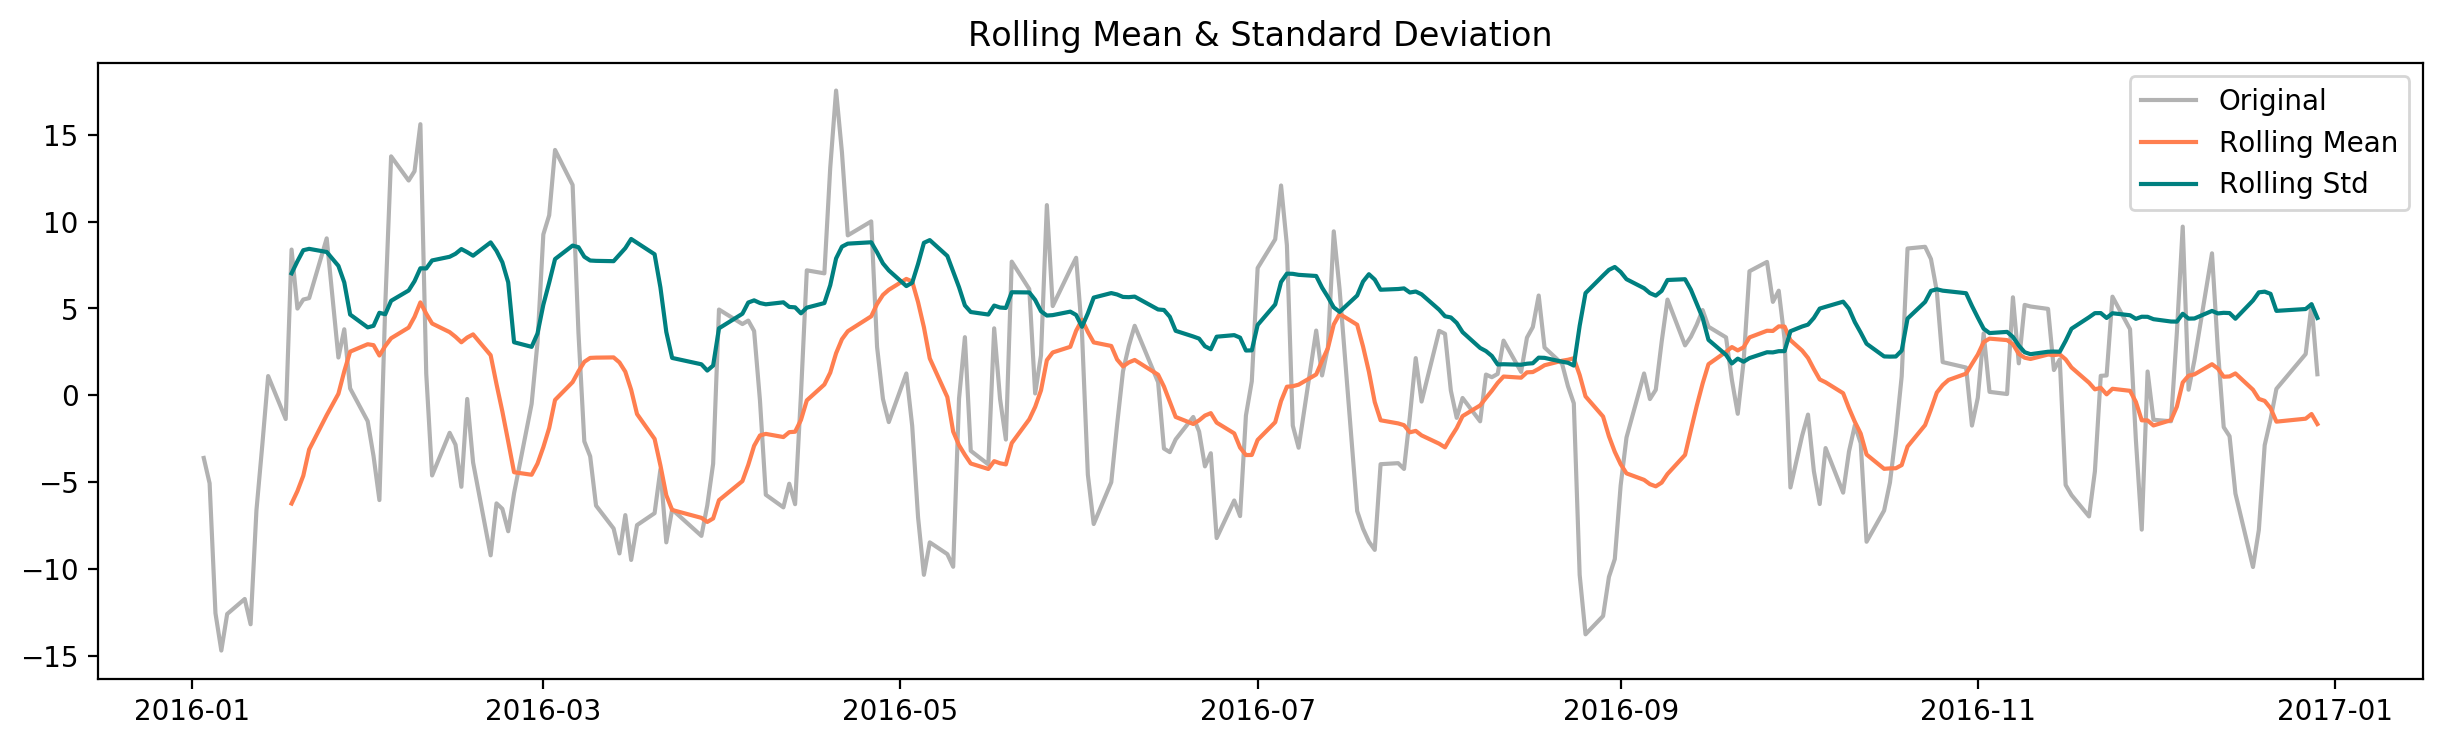

Mean MinMax Delta: 13.997230679889565
Std MinMax Delta: 7.578974850925222
ADF Statistic: -5.945576368405459
p-value: 2.2083546445760912e-07
Critical Values:
	1%: -3.4578942529658563
	5%: -2.8736593200231484
	10%: -2.573228767361111


In [16]:
af.get_stationarity(ILU_2016['rtn5_stdev'])

### Conclusion
La transformation pct_change(5) + stdev est plus stationnaire que pct_change(5) seul.

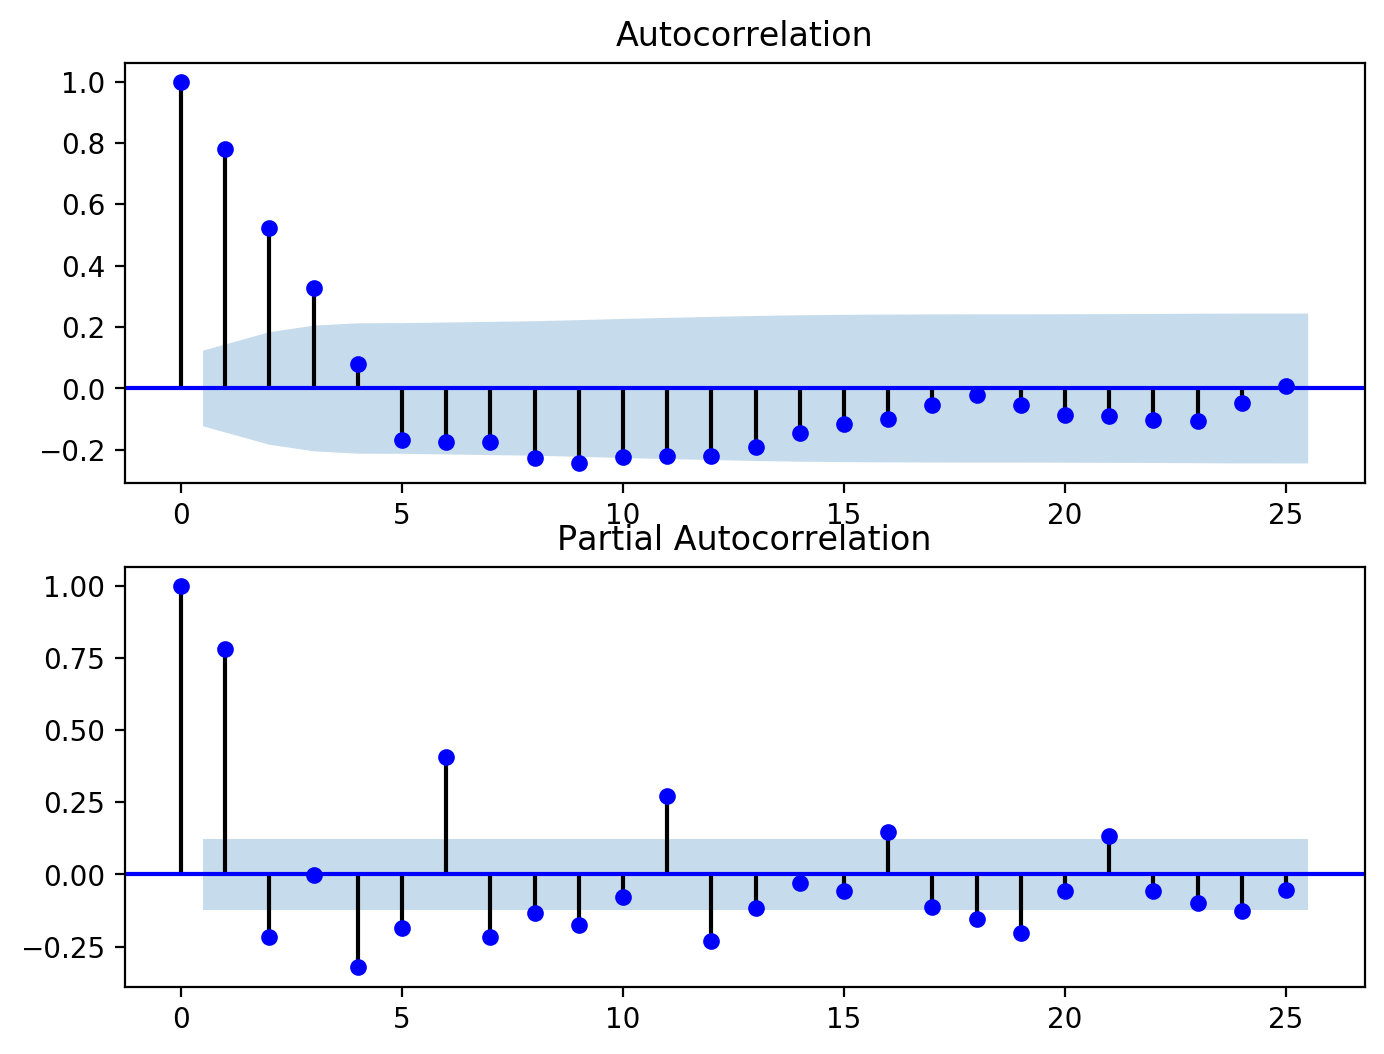

In [18]:
af.plot_corr_function(ILU_2016['rtn5_stdev'])
plt.show()

In [8]:
# Trouver le paramètre optimal sur une série de paramètre
aic_16_5_var = af.aic_optimize(ILU_2016['rtn5_stdev'], ar_max_range= 12, ma_max_range= 4)

The AIC for an ARMA(0, 0, 0) is:  1634 
The AIC for an ARMA(0, 0, 1) is:  1470 
The AIC for an ARMA(0, 0, 2) is:  1393 
The AIC for an ARMA(0, 0, 3) is:  1395 
The AIC for an ARMA(1, 0, 0) is:  1400 
The AIC for an ARMA(1, 0, 1) is:  1390 
The AIC for an ARMA(1, 0, 2) is:  1392 
The AIC for an ARMA(1, 0, 3) is:  1341 
The AIC for an ARMA(2, 0, 0) is:  1391 
The AIC for an ARMA(2, 0, 1) is:  1392 
The AIC for an ARMA(2, 0, 2) is:  1371 
The AIC for an ARMA(2, 0, 3) is:  1321 
The AIC for an ARMA(3, 0, 0) is:  1393 
The AIC for an ARMA(3, 0, 1) is:  1394 
The AIC for an ARMA(3, 0, 2) is:  1344 
The AIC for an ARMA(3, 0, 3) is:  1317 
The AIC for an ARMA(4, 0, 0) is:  1368 
The AIC for an ARMA(4, 0, 1) is:  1368 
The AIC for an ARMA(4, 0, 2) is:  1305 
The AIC for an ARMA(4, 0, 3) is:  1302 
The AIC for an ARMA(5, 0, 0) is:  1361 
The AIC for an ARMA(5, 0, 1) is:  1337 
The AIC for an ARMA(5, 0, 2) is:  1314 
The AIC for an ARMA(5, 0, 3) is:  1309 
The AIC for an ARMA(6, 0, 0) is:  1323 


ARIMA(9,0,2) sont les paramètres optimaux

In [22]:
range= list(np.arange(75, 126, 5))
ls_mean= []
ls_std= []

for i in range:
    # Entrainer un modèle ARIMA sur un rolling window
    test_df_roll= af.rollwin_ARIMA(ILU_2016['rtn5_stdev'], actual= 'rtn5_stdev', ARIMA_order= (9, 0, 2), window_size= i)
    ls_mean.append(test_df_roll['Erreur'].mean())
    ls_std.append(test_df_roll['Erreur'].std())
    
    print("___{} sur un Rolling window de: {}___".format('ILU_2016', i))
    print("Erreur moyenne: {:.3f} ".format(test_df_roll['Erreur'].mean()))
    print("Erreur Écart type: {:.3f}".format(test_df_roll['Erreur'].std()))
    print("Erreur Écart type actuel: {:.3f}".format(test_df_roll['rtn5_stdev'].std()))
    #_= test_df_roll[['Adj Close', 'Prediction']].plot()

___ILU_2016 sur un Rolling window de: 75___
Erreur moyenne: -0.018 
Erreur Écart type: 3.172
Erreur Écart type actuel: 5.264
___ILU_2016 sur un Rolling window de: 80___
Erreur moyenne: -0.068 
Erreur Écart type: 3.192
Erreur Écart type actuel: 5.123
___ILU_2016 sur un Rolling window de: 85___
Erreur moyenne: 0.021 
Erreur Écart type: 3.150
Erreur Écart type actuel: 5.106
___ILU_2016 sur un Rolling window de: 90___
Erreur moyenne: 0.091 
Erreur Écart type: 3.084
Erreur Écart type actuel: 5.022
___ILU_2016 sur un Rolling window de: 95___
Erreur moyenne: 0.164 
Erreur Écart type: 3.055
Erreur Écart type actuel: 5.070


LinAlgError: LU decomposition error.

In [23]:
plt.plot(range, ls_std)
plt.xticks(range)
plt.title('Écart type: Rollwin 75-125, x5', fontsize= 15)
plt.show()

ValueError: x and y must have same first dimension, but have shapes (11,) and (5,)

In [4]:
window_size = 85

# Get temporary df of rolling averages
df_roll_temp= af.rollwin_ARIMA(ILU_2016['rtn5_stdev'], actual= 'rtn5_stdev', ARIMA_order= (9, 0, 2), window_size= window_size)

In [5]:
# Stiching all together
df_roll_temp['rtn5'] = ILU_2016['rtn5'].iloc[window_size: :]
df_roll_temp.columns = ['rtn5_stdev', 'Pred_stdev', 'Erreur', 'rtn5']
# Selon système d'équation résolut sur papier
df_roll_temp['Pred_rtn5'] = df_roll_temp['rtn5'] - df_roll_temp['Erreur']
ILU_2016_pred = df_roll_temp.copy()


# Créer une valeur bool indiquant une différence entre la direction du retour prédit vs actuel
ILU_2016_pred['Erreur_Dir'] = ((ILU_2016_pred['rtn5'] < 0) 
                                      & (ILU_2016_pred['Pred_rtn5'] > 0)) | ((ILU_2016_pred['rtn5'] > 0) 
                                                                                    & (ILU_2016_pred['Pred_rtn5'] < 0))

In [56]:
#ILU_2016_pred.to_pickle('./_Output/ILU_2016_pred.pickle')
ILU_2016_pred

rtn5_stdev  Pred_stdev    Erreur      rtn5  Pred_rtn5  Erreur_Dir
Date                                                                         
2016-05-06   -8.474593   -9.998486  1.523893 -4.665629  -6.189522       False
2016-05-09   -9.152148  -10.742330  1.590182 -7.078311  -8.668493       False
2016-05-10   -9.881762   -7.040849 -2.840913 -9.538470  -6.697557       False
2016-05-11   -0.192171   -5.100139  4.907968 -0.487821  -5.395789       False
2016-05-12    3.342941    4.143430 -0.800489  2.483448   3.283936       False
...                ...         ...       ...       ...        ...         ...
2016-12-21   -1.395561   -2.333150  0.937589  1.587307   0.649718       False
2016-12-22    0.364465    0.250279  0.114186  2.478136   2.363949       False
2016-12-27    2.371084    3.223356 -0.852272  4.532149   5.384421       False
2016-12-28    5.236616    2.227788  3.008828  7.544391   4.535564       False
2016-12-29    1.206745    3.499877 -2.293132  2.683631   4.976763       False

[168 rows x 6 columns]

In [52]:
# Quel est le ratio de prédictions dans la bonne direction (False)
ILU_2016_pred['Erreur_Dir'].value_counts(normalize= True)

False    0.821429
True     0.178571
Name: Erreur_Dir, dtype: float64

Moyenne de l'erreur: 0.021% 
Écart type de l'erreur: 3.150%
____________________________
Retour moyen actuel: 0.512% 
Retour moyen prédit: 0.491% 
Écart type des retours actuels: 5.349%
Écart type des retours prédits: 5.188% 


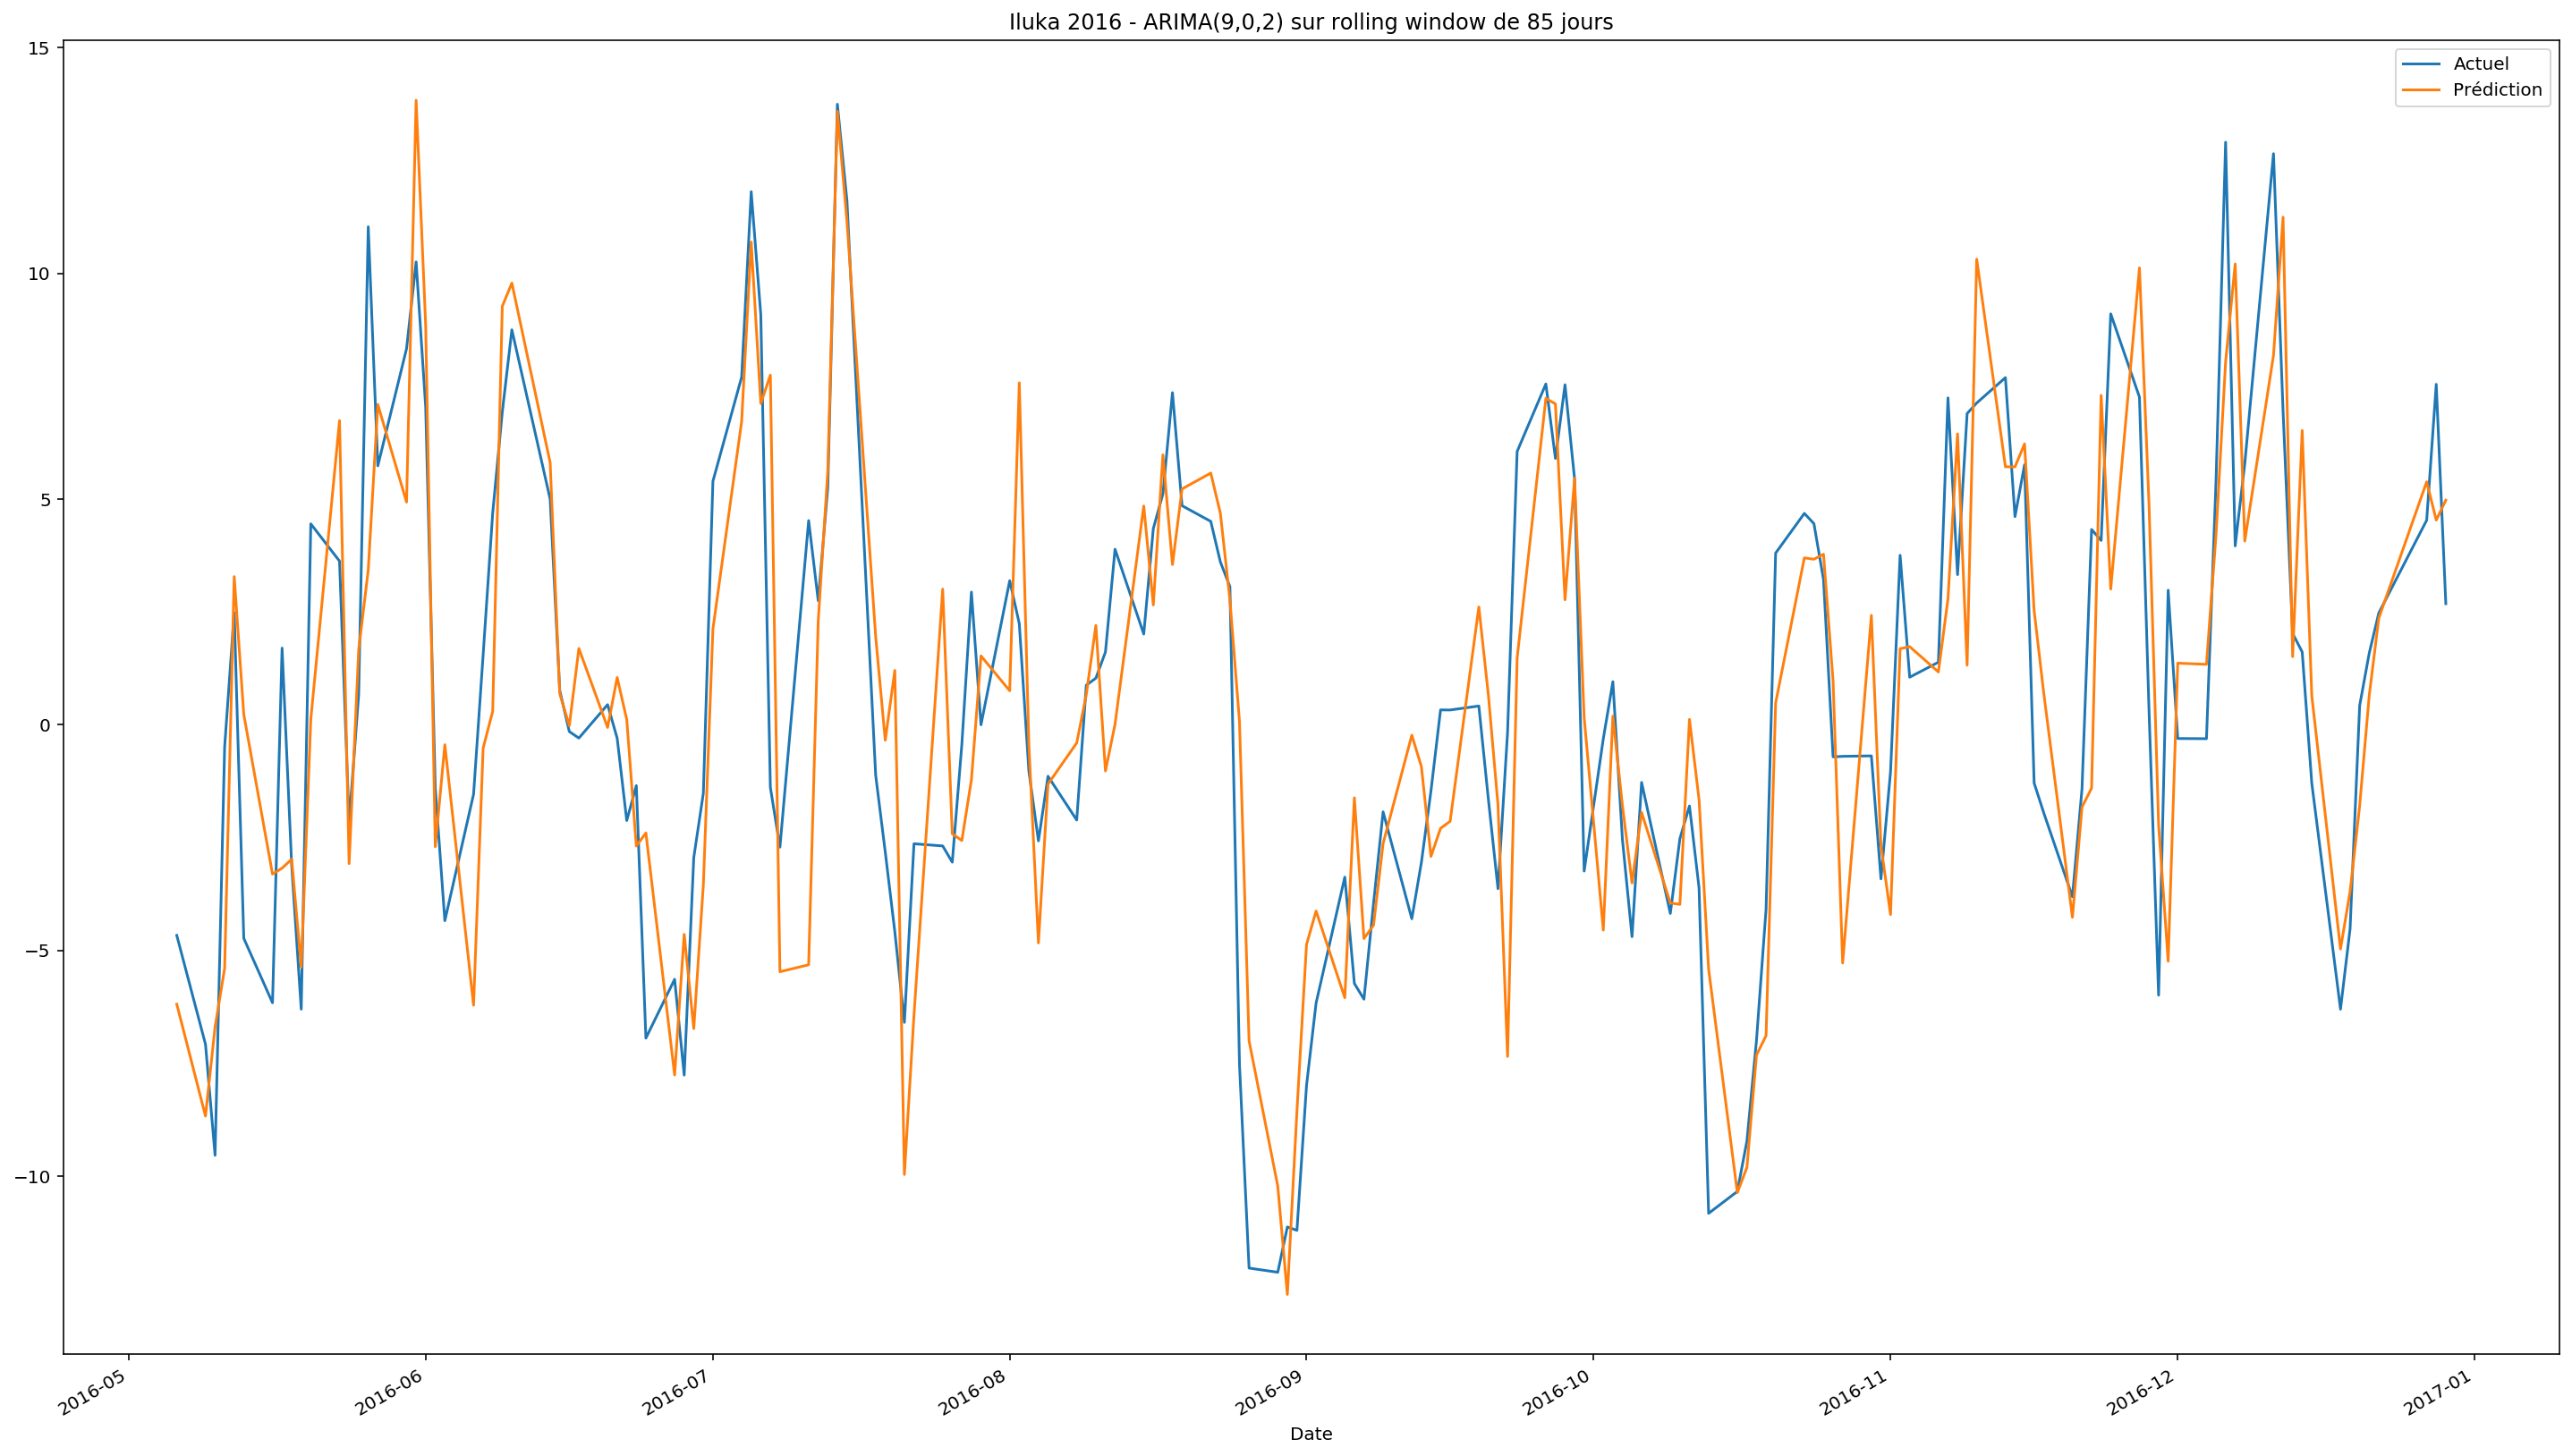

In [50]:
print("Moyenne de l'erreur: {:.3f}% ".format(ILU_2016_pred['Erreur'].mean()))
print("Écart type de l'erreur: {:.3f}%".format(ILU_2016_pred['Erreur'].std()))
print('____________________________')
print("Retour moyen actuel: {:.3f}% ".format(ILU_2016_pred['rtn5'].mean()))
print("Retour moyen prédit: {:.3f}% ".format(ILU_2016_pred['Pred_rtn5'].mean()))
print("Écart type des retours actuels: {:.3f}%".format(ILU_2016_pred['rtn5'].std()))
print("Écart type des retours prédits: {:.3f}% ".format(ILU_2016_pred['Pred_rtn5'].std()))
_ = ILU_2016_pred[['rtn5', 'Pred_rtn5']].plot(figsize= [25, 15])
_ = plt.legend(('Actuel', 'Prédiction'))
_ = plt.title('Iluka 2016 - ARIMA(9,0,2) sur rolling window de 85 jours')
plt.show()

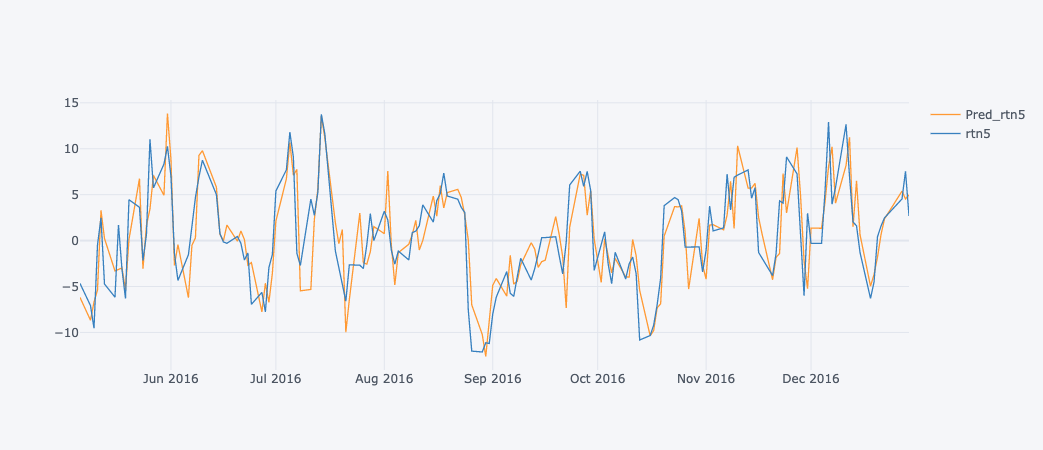

In [8]:
ILU_2016_pred[['Pred_rtn5', 'rtn5']].iplot()

## Iluka 2017

In [31]:
store -r

In [32]:
ILU_2017 = ILU.loc['2017']

In [34]:
window_size = 85

# Get temporary df of rolling averages
ILU_2017_pred= af.rollwin_ARIMA(ILU_2017['rtn5_stdev'], actual= 'rtn5_stdev', ARIMA_order= (9, 0, 2), window_size= window_size)

In [35]:
# Stiching all together
ILU_2017_pred['rtn5'] = ILU_2017['rtn5'].iloc[window_size: :]
ILU_2017_pred.columns = ['rtn5_stdev', 'Pred_stdev', 'Erreur', 'rtn5']
# Selon système d'équation résolut sur papier
ILU_2017_pred['Pred_rtn5'] = ILU_2017_pred['rtn5'] - ILU_2017_pred['Erreur']


# Créer une valeur bool indiquant une différence entre la direction du retour prédit vs actuel
ILU_2017_pred['Erreur_Dir'] = ((ILU_2017_pred['rtn5'] < 0) 
                                      & (ILU_2017_pred['Pred_rtn5'] > 0)) | ((ILU_2017_pred['rtn5'] > 0) 
                                                                                    & (ILU_2017_pred['Pred_rtn5'] < 0))

In [36]:
#ILU_2017_pred.to_pickle('./_Output/ILU_2017_pred.pickle')
ILU_2017_pred

rtn5_stdev  Pred_stdev    Erreur      rtn5  Pred_rtn5  Erreur_Dir
Date                                                                         
2017-05-08  -10.841315  -11.192599  0.351284 -7.142842  -7.494126       False
2017-05-09   -7.920185   -9.424315  1.504129 -5.250589  -6.754718       False
2017-05-10   -4.519403   -5.240490  0.721086 -3.008421  -3.729508       False
2017-05-11   -1.355476    3.017227 -4.372703 -1.577667   2.795036        True
2017-05-12    8.378438    3.914106  4.464332  7.525510   3.061178       False
...                ...         ...       ...       ...        ...         ...
2017-12-20    2.412171    2.393392  0.018778  4.900962   4.882184       False
2017-12-21    2.722305    1.489102  1.233204  5.962345   4.729141       False
2017-12-26    1.238269    1.131861  0.106408  4.963797   4.857389       False
2017-12-27   -2.028741   -1.499661 -0.529081  1.900021   2.429102       False
2017-12-28   -2.392750   -2.875385  0.482635  1.497006   1.014372       False

[167 rows x 6 columns]

In [37]:
# Quel est le ratio de prédictions dans la bonne direction (False)
ILU_2017_pred['Erreur_Dir'].value_counts(normalize= True)

False    0.868263
True     0.131737
Name: Erreur_Dir, dtype: float64

Moyenne de l'erreur: 0.033% 
Écart type de l'erreur: 1.736%
____________________________
Retour moyen actuel: 0.708% 
Retour moyen prédit: 0.675% 
Écart type des retours actuels: 3.576%
Écart type des retours prédits: 3.231% 


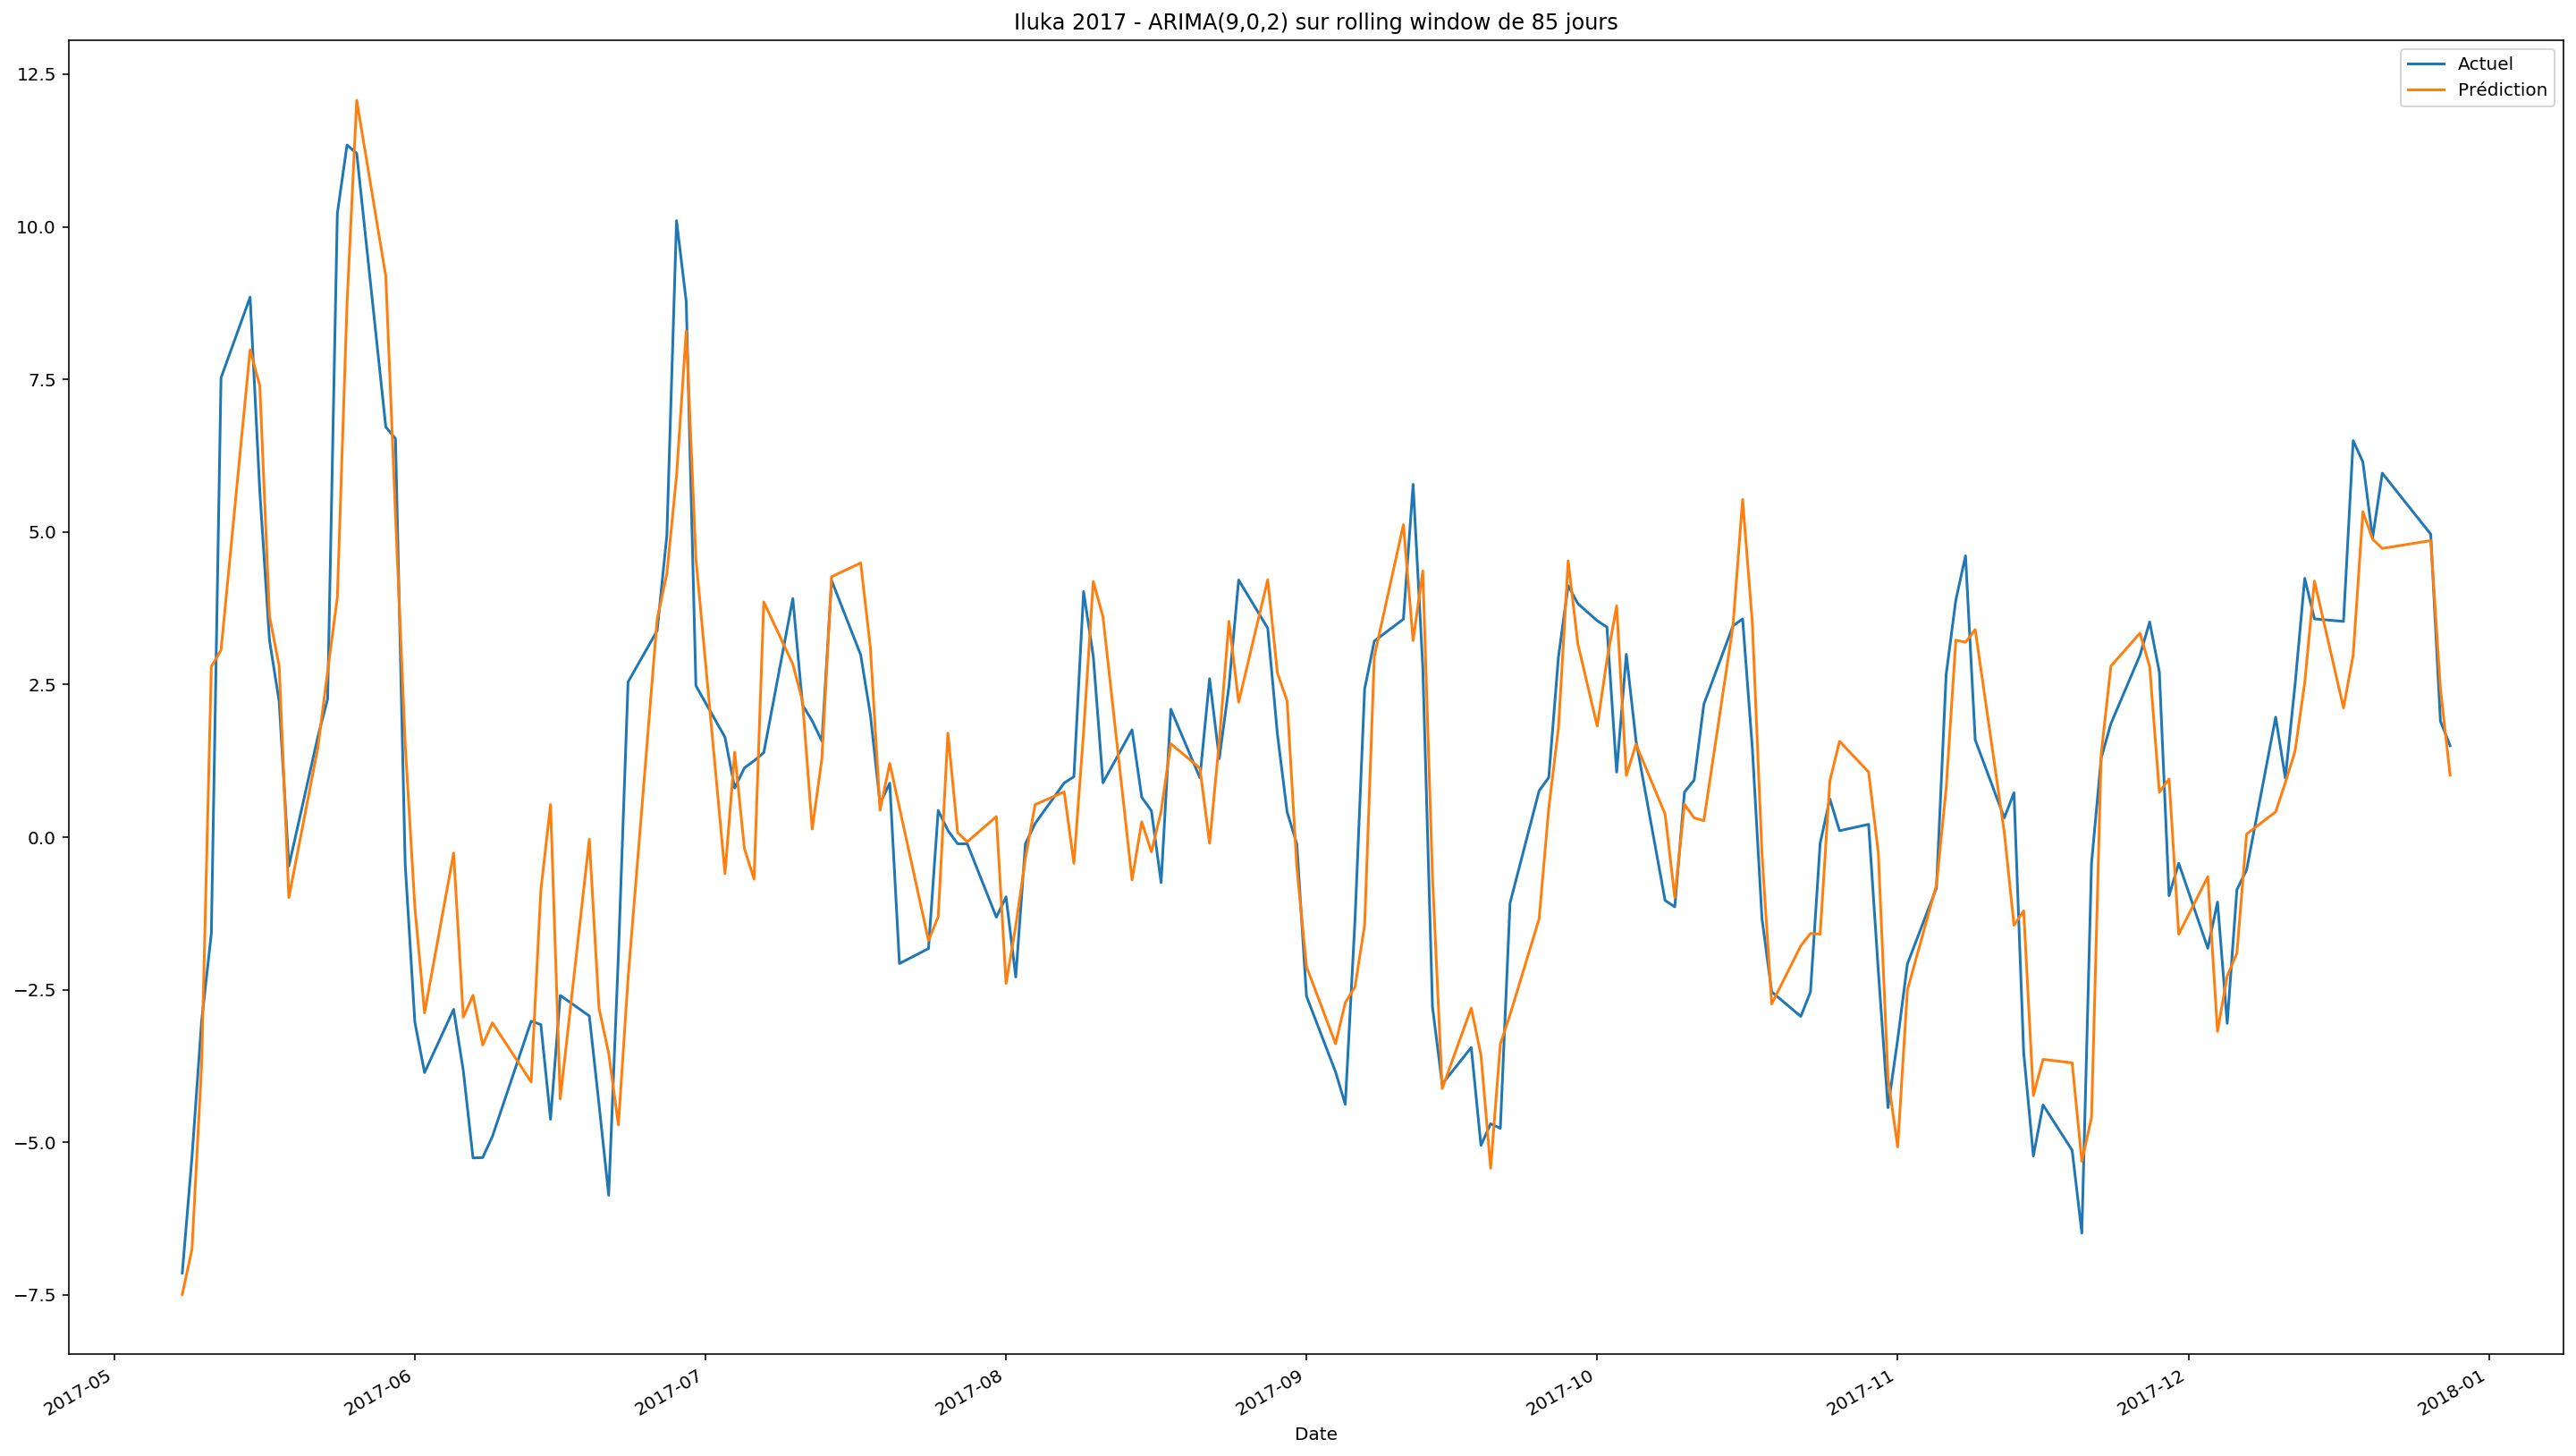

In [68]:
print("Moyenne de l'erreur: {:.3f}% ".format(ILU_2017_pred['Erreur'].mean()))
print("Écart type de l'erreur: {:.3f}%".format(ILU_2017_pred['Erreur'].std()))
print('____________________________')
print("Retour moyen actuel: {:.3f}% ".format(ILU_2017_pred['rtn5'].mean()))
print("Retour moyen prédit: {:.3f}% ".format(ILU_2017_pred['Pred_rtn5'].mean()))
print("Écart type des retours actuels: {:.3f}%".format(ILU_2017_pred['rtn5'].std()))
print("Écart type des retours prédits: {:.3f}% ".format(ILU_2017_pred['Pred_rtn5'].std()))
_ = ILU_2017_pred[['rtn5', 'Pred_rtn5']].plot(figsize= [25, 15])
_ = plt.legend(('Actuel', 'Prédiction'))
_ = plt.title('Iluka 2017 - ARIMA(9,0,2) sur rolling window de 85 jours')
plt.show()

In [ ]:
ILU_2016_pred.iplot()

In [ ]:
np.polyfit()

In [11]:
# set up config (run once)
#cf.set_config_file(world_readable= True, theme= 'pearl', offline= True)
init_notebook_mode()

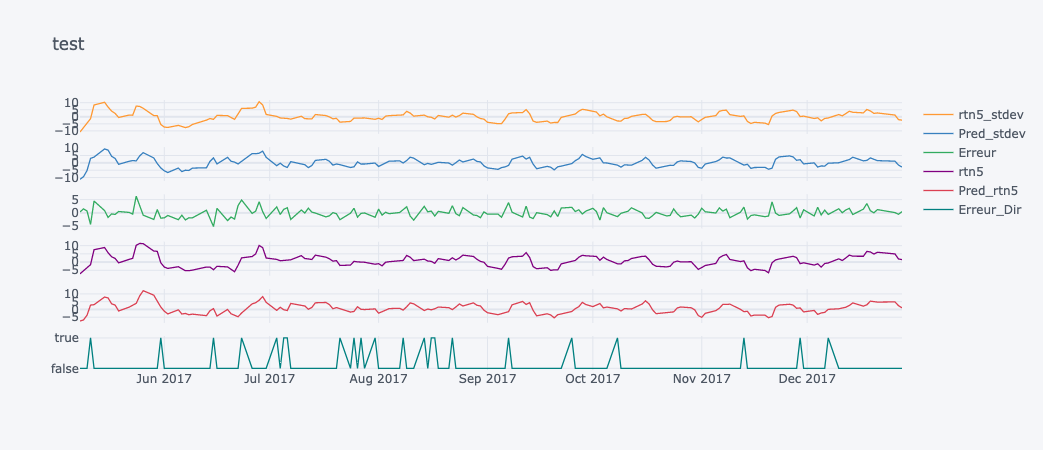

In [14]:
ILU_2017_pred.iplot(subplots= True, shape= (6,1), shared_xaxes= True, title= 'test')

In [72]:
ILU_2017_pred.head()

rtn5_stdev  Pred_stdev    Erreur      rtn5  Pred_rtn5  Erreur_Dir
Date                                                                         
2017-05-08  -10.841315  -11.192599  0.351284 -7.142842  -7.494126       False
2017-05-09   -7.920185   -9.424315  1.504129 -5.250589  -6.754718       False
2017-05-10   -4.519403   -5.240490  0.721086 -3.008421  -3.729508       False
2017-05-11   -1.355476    3.017227 -4.372703 -1.577667   2.795036        True
2017-05-12    8.378438    3.914106  4.464332  7.525510   3.061178       False

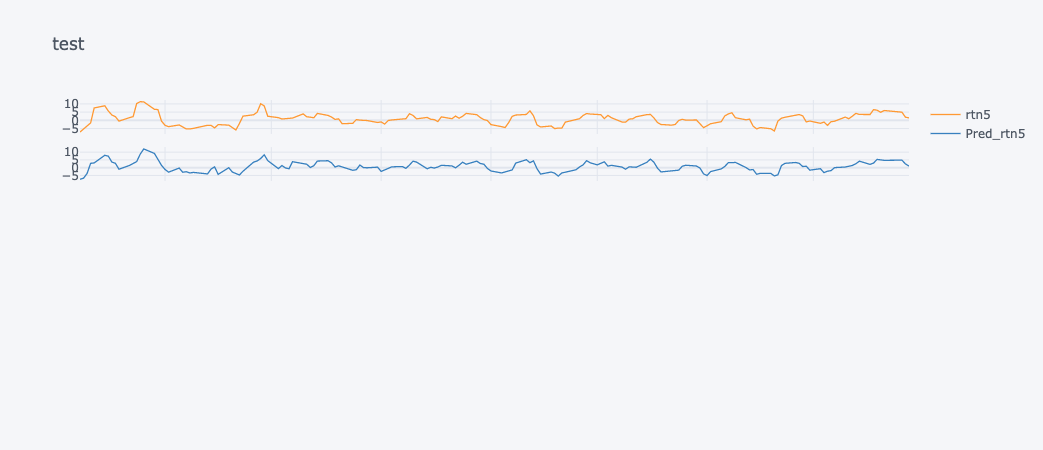

In [74]:
ILU_2017_pred[['rtn5', 'Pred_rtn5']].iplot(subplots= True, shape= (6,1), shared_xaxes= True, title= 'test')

In [13]:
%load_ext autoreload
%autoreload 2

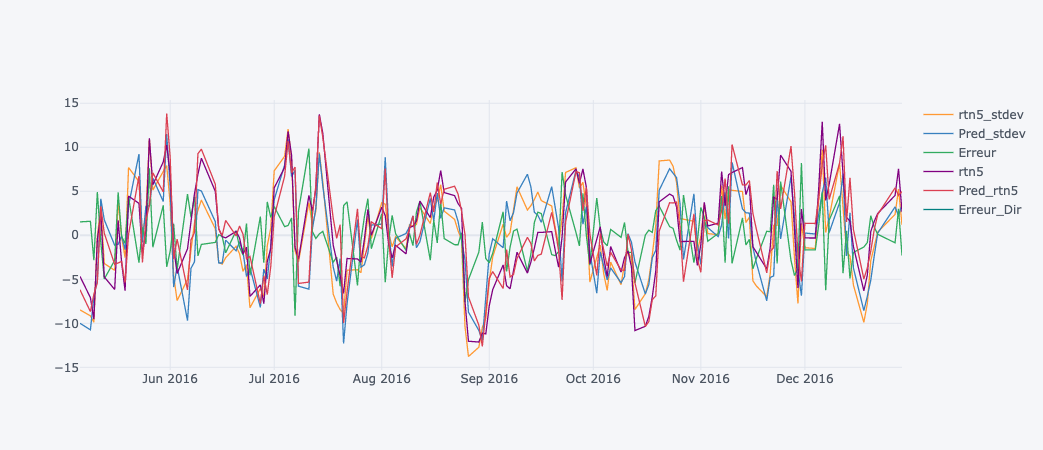

In [77]:
ILU_2016_pred.iplot()

In [11]:
!jupyter lab PUS20-06_ML_analysis.ipynb

[I 11:02:52.616 LabApp] The port 8888 is already in use, trying another port.
[I 11:02:52.617 LabApp] The port 8889 is already in use, trying another port.
[I 11:02:52.618 LabApp] The port 8890 is already in use, trying another port.
[I 11:02:52.706 LabApp] [jupyter_nbextensions_configurator] enabled 0.4.1
[I 11:02:53.017 LabApp] JupyterLab extension loaded from /anaconda3/envs/FinBoys/lib/python3.8/site-packages/jupyterlab
[I 11:02:53.018 LabApp] JupyterLab application directory is /anaconda3/envs/FinBoys/share/jupyter/lab
[I 11:02:53.298 LabApp] Serving notebooks from local directory: /Users/jonathanbeaulieu/Documents/PROG/Data_processing/smart_halo-persona_data_analysis/persona_data_analysis
[I 11:02:53.299 LabApp] The Jupyter Notebook is running at:
[I 11:02:53.299 LabApp] http://localhost:8891/?token=63da77059828d5eab330e95ec51bf4a1a1406c914dd981ad
[I 11:02:53.299 LabApp]  or http://127.0.0.1:8891/?token=63da77059828d5eab330e95ec51bf4a1a1406c914dd981ad
[I 11:02:53.299 LabApp] Use 

## Stratégie d'investissement
### test ILU_2016

In [3]:
ILU_2016 = pd.read_pickle('_Output/ILU_2016_pred.pickle')
ILU_2016.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 168 entries, 2016-05-06 to 2016-12-29
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   rtn5_stdev  168 non-null    float64
 1   Pred_stdev  168 non-null    float64
 2   Erreur      168 non-null    float64
 3   rtn5        168 non-null    float64
 4   Pred_rtn5   168 non-null    float64
 5   Erreur_Dir  168 non-null    bool   
dtypes: bool(1), float64(5)
memory usage: 8.0 KB


In [4]:
ILU_2016

rtn5_stdev  Pred_stdev    Erreur      rtn5  Pred_rtn5  Erreur_Dir
Date                                                                         
2016-05-06   -8.474593   -9.998486  1.523893 -4.665629  -6.189522       False
2016-05-09   -9.152148  -10.742330  1.590182 -7.078311  -8.668493       False
2016-05-10   -9.881762   -7.040849 -2.840913 -9.538470  -6.697557       False
2016-05-11   -0.192171   -5.100139  4.907968 -0.487821  -5.395789       False
2016-05-12    3.342941    4.143430 -0.800489  2.483448   3.283936       False
...                ...         ...       ...       ...        ...         ...
2016-12-21   -1.395561   -2.333150  0.937589  1.587307   0.649718       False
2016-12-22    0.364465    0.250279  0.114186  2.478136   2.363949       False
2016-12-27    2.371084    3.223356 -0.852272  4.532149   5.384421       False
2016-12-28    5.236616    2.227788  3.008828  7.544391   4.535564       False
2016-12-29    1.206745    3.499877 -2.293132  2.683631   4.976763       False

[168 rows x 6 columns]

In [8]:
store -r

In [10]:
# Merge les deux DataFrames
ILU_ = ILU.copy()
ILU_ = pd.merge(ILU, ILU_2016, left_index= True, right_index= True, how='outer')
ILU_.index = pd.to_datetime(ILU.index)
ILU_

volume  adjclose    rtn5_x  rtn5_stdev_x Dividends  rtn5_stdev_y  \
Date                                                                            
2014-01-01   990173  7.604320       NaN           NaN       NaN           NaN   
2014-01-02  1172097  7.595639       NaN           NaN       NaN           NaN   
2014-01-05  1271133  7.560915       NaN           NaN       NaN           NaN   
2014-01-06  1394498  7.456748       NaN           NaN       NaN           NaN   
2014-01-07  1037075  7.448067       NaN           NaN       NaN           NaN   
...             ...       ...       ...           ...       ...           ...   
2019-12-22   894094  9.251048 -2.809562     -2.876544       NaN           NaN   
2019-12-23   379372  9.211429 -2.105264     -2.075589       NaN           NaN   
2019-12-26   720257  9.419429  1.602570      1.675814       NaN           NaN   
2019-12-29   779816  9.330286 -0.527978     -0.038144       NaN           NaN   
2019-12-30   698256  9.211429 -1.168971     -0.510951       NaN           NaN   

            Pred_stdev  Erreur  rtn5_y  Pred_rtn5 Erreur_Dir  test  
Date                                                                
2014-01-01         NaN     NaN     NaN        NaN        NaN   NaN  
2014-01-02         NaN     NaN     NaN        NaN        NaN   NaN  
2014-01-05         NaN     NaN     NaN        NaN        NaN   NaN  
2014-01-06         NaN     NaN     NaN        NaN        NaN   NaN  
2014-01-07         NaN     NaN     NaN        NaN        NaN   NaN  
...                ...     ...     ...        ...        ...   ...  
2019-12-22         NaN     NaN     NaN        NaN        NaN   NaN  
2019-12-23         NaN     NaN     NaN        NaN        NaN   NaN  
2019-12-26         NaN     NaN     NaN        NaN        NaN   NaN  
2019-12-29         NaN     NaN     NaN        NaN        NaN   NaN  
2019-12-30         NaN     NaN     NaN        NaN        NaN   NaN  

[1519 rows x 12 columns]

In [14]:
ILU_['Adj_Close+5'] = ILU_['adjclose'].shift(5)
ILU_['Pred_Adj_Close'] = ILU_['Adj_Close+5'] * (1 + (ILU_['Pred_rtn5'] / 100))
ILU_['Pred_AC_j+5'] = ILU_['Pred_Adj_Close'].shift(-5)
ILU_.loc['2016-05-06':'2016-12-29']

volume  adjclose    rtn5_x  rtn5_stdev_x Dividends  rtn5_stdev_y  \
Date                                                                            
2016-05-06  2892348  5.645028 -4.665629     -8.474593       NaN     -8.474593   
2016-05-09  2319604  5.681863 -7.078311     -9.152148       NaN     -9.152148   
2016-05-10  4101805  5.414806 -9.538470     -9.881762       NaN     -9.881762   
2016-05-11  2768790  5.635819 -0.487821     -0.192171       NaN     -0.192171   
2016-05-12  3405050  5.700282  2.483448      3.342941       NaN      3.342941   
...             ...       ...       ...           ...       ...           ...   
2016-12-21  1562858  6.514658  1.587307     -1.395561       NaN     -1.395561   
2016-12-22  1126152  6.505405  2.478136      0.364465       NaN      0.364465   
2016-12-27   864256  6.616450  4.532149      2.371084       NaN      2.371084   
2016-12-28   941025  6.727496  7.544391      5.236616       NaN      5.236616   
2016-12-29   898545  6.727496  2.683631      1.206745       NaN      1.206745   

            Pred_stdev    Erreur    rtn5_y  Pred_rtn5 Erreur_Dir      test  \
Date                                                                         
2016-05-06   -9.998486  1.523893 -4.665629  -6.189522      False -4.730826   
2016-05-09  -10.742330  1.590182 -7.078311  -8.668493      False -6.158833   
2016-05-10   -7.040849 -2.840913 -9.538470  -6.697557      False  1.700683   
2016-05-11   -5.100139  4.907968 -0.487821  -5.395789      False -3.104567   
2016-05-12    4.143430 -0.800489  2.483448   3.283936      False -6.300489   
...                ...       ...       ...        ...        ...       ...   
2016-12-21   -2.333150  0.937589  1.587307   0.649718      False       NaN   
2016-12-22    0.250279  0.114186  2.478136   2.363949      False       NaN   
2016-12-27    3.223356 -0.852272  4.532149   5.384421      False       NaN   
2016-12-28    2.227788  3.008828  7.544391   4.535564      False       NaN   
2016-12-29    3.499877 -2.293132  2.683631   4.976763      False       NaN   

            Adj_Close+5  Pred_Adj_Close  Pred_AC_j+5  
Date                                                  
2016-05-06     5.921294        5.554794     5.657949  
2016-05-09     6.114679        5.584629     5.493986  
2016-05-10     5.985756        5.584856     5.242827  
2016-05-11     5.663446        5.357859     5.468019  
2016-05-12     5.562149        5.744806     5.394239  
...                 ...             ...          ...  
2016-12-21     6.412867        6.454532          NaN  
2016-12-22     6.348091        6.498156          NaN  
2016-12-27     6.329584        6.670395          NaN  
2016-12-28     6.255553        6.539277          NaN  
2016-12-29     6.551673        6.877735          NaN  

[168 rows x 15 columns]

In [18]:
ILU_2016_pred = ILU_.loc['2016-05-06':'2016-12-29']
print(ILU_2016_pred.shape)
ILU_2016_pred_simp = ILU_2016_pred[['adjclose', 'Pred_AC_j+5']].dropna()
print(ILU_2016_pred_simp.shape)

(168, 15)
(163, 2)


In [20]:
ILU_2016_pred_simp.head()

adjclose  Pred_AC_j+5
Date                             
2016-05-06  5.645028     5.657949
2016-05-09  5.681863     5.493986
2016-05-10  5.414806     5.242827
2016-05-11  5.635819     5.468019
2016-05-12  5.700282     5.394239

In [22]:
from FinForecast import InvestStrat

In [23]:
ILU_2016_pred_simp = InvestStrat.add_returns(ILU_2016_pred_simp, 
                                             prediction_col= 'Pred_AC_j+5', 
                                             actual_col= 'adjclose')

ILU_2016_pred_simp = InvestStrat.AutoLabel(ILU_2016_pred_simp)
ILU_2016_pred_simp

adjclose  Pred_AC_j+5  pred_rtn  actual_rtn Position_label
Date                                                                  
2016-05-06  5.645028     5.657949  0.002284         NaN           Hold
2016-05-09  5.681863     5.493986 -0.034197    0.006525           Hold
2016-05-10  5.414806     5.242827 -0.032803   -0.047002           Hold
2016-05-11  5.635819     5.468019 -0.030687    0.040816           Hold
2016-05-12  5.700282     5.394239 -0.056735    0.011438           Hold
...              ...          ...       ...         ...            ...
2016-12-14  6.412867     6.454532  0.006455   -0.017021            Buy
2016-12-15  6.348091     6.498156  0.023094   -0.010101           Hold
2016-12-18  6.329584     6.670395  0.051093   -0.002915           Hold
2016-12-19  6.255553     6.539277  0.043388   -0.011696           Hold
2016-12-20  6.551673     6.877735  0.047408    0.047337           Hold

[163 rows x 5 columns]

In [26]:
fond = 100
total = InvestStrat.TradeTest(ILU_2016_pred_simp, fond= fond, close_value_col= 'adjclose')
actif = total + ILU_2016_pred_simp['adjclose'][-1]
rendement = (actif - fond) / fond * 100
print("L'actif total est de: {:.2f}$".format(actif))
print("Le rendement est de {:.2f}%".format(rendement))

L'actif total est de: 104.81$
Le rendement est de 4.81%


### Test ILU_2017

In [ ]:
#ILU_2017_pred = pd.read_pickle('_Output/ILU_2017_pred.pickle')

In [39]:
ILU_2017_pred

rtn5_stdev  Pred_stdev    Erreur      rtn5  Pred_rtn5  Erreur_Dir
Date                                                                         
2017-05-08  -10.841315  -11.192599  0.351284 -7.142842  -7.494126       False
2017-05-09   -7.920185   -9.424315  1.504129 -5.250589  -6.754718       False
2017-05-10   -4.519403   -5.240490  0.721086 -3.008421  -3.729508       False
2017-05-11   -1.355476    3.017227 -4.372703 -1.577667   2.795036        True
2017-05-12    8.378438    3.914106  4.464332  7.525510   3.061178       False
...                ...         ...       ...       ...        ...         ...
2017-12-20    2.412171    2.393392  0.018778  4.900962   4.882184       False
2017-12-21    2.722305    1.489102  1.233204  5.962345   4.729141       False
2017-12-26    1.238269    1.131861  0.106408  4.963797   4.857389       False
2017-12-27   -2.028741   -1.499661 -0.529081  1.900021   2.429102       False
2017-12-28   -2.392750   -2.875385  0.482635  1.497006   1.014372       False

[167 rows x 6 columns]

In [40]:
# Merge les deux DataFrames
ILU_ = ILU.copy()
ILU_ = pd.merge(ILU, ILU_2017_pred, left_index= True, right_index= True, how='outer')
ILU_.index = pd.to_datetime(ILU.index)
ILU_['Adj_Close+5'] = ILU_['adjclose'].shift(5)
ILU_['Pred_Adj_Close'] = ILU_['Adj_Close+5'] * (1 + (ILU_['Pred_rtn5'] / 100))
ILU_['Pred_AC_j+5'] = ILU_['Pred_Adj_Close'].shift(-5)
ILU_.loc['2017-05-08':'2017-12-28'].head()

volume  adjclose    rtn5_x  rtn5_stdev_x Dividends  rtn5_stdev_y  \
Date                                                                            
2017-05-08  3697864  7.217946 -7.142842    -10.841315       NaN    -10.841315   
2017-05-09  3174889  7.347498 -5.250589     -7.920185       NaN     -7.920185   
2017-05-10  6771398  7.458544 -3.008421     -4.519403       NaN     -4.519403   
2017-05-11  1768775  7.504812 -1.577667     -1.355476       NaN     -1.355476   
2017-05-12  2576131  7.800934  7.525510      8.378438       NaN      8.378438   
...             ...       ...       ...           ...       ...           ...   
2017-12-20  1886430  9.367544  4.900962      2.412171       NaN      2.412171   
2017-12-21  1662698  9.432725  5.962345      2.722305       NaN      2.722305   
2017-12-26   443843  9.451346  4.963797      1.238269       NaN      1.238269   
2017-12-27   471040  9.488595  1.900021     -2.028741       NaN     -2.028741   
2017-12-28   625779  9.469972  1.497006     -2.392750       NaN     -2.392750   

            Pred_stdev    Erreur    rtn5_y  Pred_rtn5 Erreur_Dir  Adj_Close+5  \
Date                                                                            
2017-05-08  -11.192599  0.351284 -7.142842  -7.494126      False     7.773171   
2017-05-09   -9.424315  1.504129 -5.250589  -6.754718      False     7.754664   
2017-05-10   -5.240490  0.721086 -3.008421  -3.729508      False     7.689888   
2017-05-11    3.017227 -4.372703 -1.577667   2.795036       True     7.625111   
2017-05-12    3.914106  4.464332  7.525510   3.061178      False     7.254961   
...                ...       ...       ...        ...        ...          ...   
2017-12-20    2.393392  0.018778  4.900962   4.882184      False     8.929893   
2017-12-21    1.489102  1.233204  5.962345   4.729141      False     8.901959   
2017-12-26    1.131861  0.106408  4.963797   4.857389      False     9.004387   
2017-12-27   -1.499661 -0.529081  1.900021   2.429102      False     9.311671   
2017-12-28   -2.875385  0.482635  1.497006   1.014372      False     9.330297   

            Pred_Adj_Close  Pred_AC_j+5  
Date                                     
2017-05-08        7.190640     7.794365  
2017-05-09        7.230858     7.890890  
2017-05-10        7.403093     7.728664  
2017-05-11        7.838236     7.715012  
2017-05-12        7.477048     7.723536  
...                    ...          ...  
2017-12-20        9.365867          NaN  
2017-12-21        9.322946          NaN  
2017-12-26        9.441765          NaN  
2017-12-27        9.537861          NaN  
2017-12-28        9.424940          NaN  

[167 rows x 14 columns]

In [47]:
ILU_2017_pred = ILU_.loc['2017-05-08':'2017-12-28']
print(ILU_2017_pred.shape)
ILU_2017_pred_simp = ILU_2017_pred[['adjclose', 'Pred_AC_j+5']].dropna()
print(ILU_2017_pred_simp.shape)

(167, 14)
(162, 2)


In [75]:
# del ILU_2017_pred_simp['Position_label']

In [76]:
ILU_2017_pred_simp = InvestStrat.add_returns(ILU_2017_pred_simp, 
                                             prediction_col= 'Pred_AC_j+5', 
                                             actual_col= 'adjclose')
ILU_2017_pred_simp['actual_rtn'].iloc[0] = -.05

ILU_2017_pred_simp = InvestStrat.AutoLabel(ILU_2017_pred_simp, hold_count_max=4)
ILU_2017_pred_simp

adjclose  Pred_AC_j+5  pred_rtn  actual_rtn Position_label
Date                                                                  
2017-05-08  7.217946     7.794365  0.073953   -0.050000            Buy
2017-05-09  7.347498     7.890890  0.068863    0.017949           Hold
2017-05-10  7.458544     7.728664  0.034950    0.015113           Hold
2017-05-11  7.504812     7.715012  0.027246    0.006203           Hold
2017-05-12  7.800934     7.723536 -0.010021    0.039458           Hold
...              ...          ...       ...         ...            ...
2017-12-13  8.929893     9.365867  0.046549    0.015890           Hold
2017-12-14  8.901959     9.322946  0.045156   -0.003128           Hold
2017-12-17  9.004387     9.441765  0.046324    0.011506           Hold
2017-12-18  9.311671     9.537861  0.023715    0.034126           Hold
2017-12-19  9.330297     9.424940  0.010042    0.002000           Hold

[162 rows x 5 columns]

In [85]:
ILU_2017_pred_simp.iloc[120:]

adjclose  Pred_AC_j+5  pred_rtn  actual_rtn Position_label
Date                                                                  
2017-10-23  8.939206     8.916436 -0.002554    0.002088           Hold
2017-10-24  9.032323     8.675487 -0.041132    0.010417           Hold
2017-10-25  8.985764     8.529515 -0.053491   -0.005155           Sell
2017-10-26  8.957829     8.733285 -0.025711   -0.003109           Hold
2017-10-29  8.939206     8.869029 -0.007913   -0.002079           Hold
2017-10-30  8.743661     8.812982  0.007866   -0.021875            Buy
2017-10-31  8.631921     8.910465  0.031260   -0.012780           Hold
2017-11-01  8.687791     8.965104  0.030933    0.006472           Hold
2017-11-02  8.771596     9.069912  0.032891    0.009646           Hold
2017-11-05  8.864713     8.871567  0.000773    0.010616           Hold
2017-11-06  8.976452     8.846749 -0.014661    0.012605           Hold
2017-11-07  8.967141     8.858762 -0.012234   -0.001037           Hold
2017-11-08  9.088193     8.703448 -0.044206    0.013499           Sell
2017-11-09  8.911270     8.586728 -0.037796   -0.019467           Hold
2017-11-12  8.892649     8.563729 -0.038409   -0.002090           Hold
2017-11-13  9.041634     8.561097 -0.056130    0.016754           Hold
2017-11-14  8.650543     8.253063 -0.048162   -0.043254           Hold
2017-11-15  8.613297     8.731014  0.013483   -0.004306            Buy
2017-11-16  8.520180     8.758867  0.027251   -0.010811           Hold
2017-11-19  8.436376     8.718212  0.032327   -0.009836           Hold
2017-11-20  8.454998     8.691280  0.027186    0.002207           Hold
2017-11-21  8.613297     8.676635  0.007300    0.018723           Hold
2017-11-22  8.725038     8.808205  0.009442    0.012973           Hold
2017-11-23  8.678478     8.540402 -0.016167   -0.005336           Hold
2017-11-26  8.687791     8.631384 -0.006535    0.001073           Hold
2017-11-27  8.752972     8.474242 -0.032891    0.007503           Hold
2017-11-28  8.846089     8.644749 -0.023291    0.010638           Sell
2017-11-29  8.641232     8.476816 -0.019396   -0.023158           Hold
2017-11-30  8.641232     8.645429  0.000485    0.000000           Hold
2017-12-03  8.529491     8.564751  0.004117   -0.012931            Buy
2017-12-04  8.659856     8.737172  0.008849    0.015284           Hold
2017-12-05  8.576051     8.696744  0.013878   -0.009677           Hold
2017-12-06  8.566739     8.783680  0.024698   -0.001086           Hold
2017-12-07  8.594674     8.955335  0.040273    0.003261           Hold
2017-12-10  8.697104     8.881187  0.020727    0.011918           Hold
2017-12-11  8.743661     9.004367  0.028953    0.005353           Hold
2017-12-12  8.790218     9.258840  0.050613    0.005325           Hold
2017-12-13  8.929893     9.365867  0.046549    0.015890           Hold
2017-12-14  8.901959     9.322946  0.045156   -0.003128           Hold
2017-12-17  9.004387     9.441765  0.046324    0.011506           Hold
2017-12-18  9.311671     9.537861  0.023715    0.034126           Hold
2017-12-19  9.330297     9.424940  0.010042    0.002000           Hold

In [77]:
fond = 100
total = InvestStrat.TradeTest(ILU_2017_pred_simp, fond= fond, close_value_col= 'adjclose')
actif = total + ILU_2017_pred_simp['adjclose'][-1]
rendement = (actif - fond) / fond * 100
print("L'actif total est de: {:.2f}$".format(actif))
print("Le rendement est de {:.2f}%".format(rendement))

L'actif total est de: 105.71$
Le rendement est de 5.71%


In [56]:
ILU_2017_pred_simp[ILU_2017_pred_simp['actual_rtn'] > 0].loc[:,'actual_rtn'].sum()

1.0625782225729539

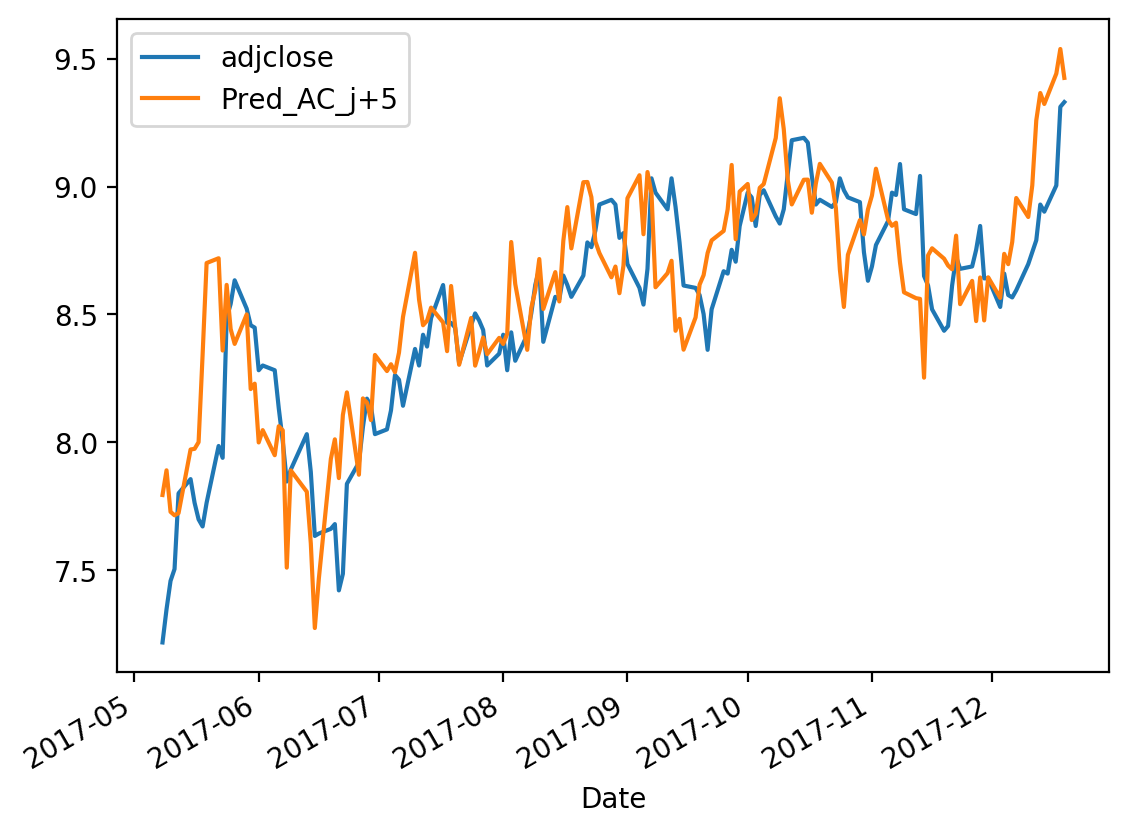

In [80]:
ILU_2017_pred_simp[['adjclose', 'Pred_AC_j+5']].plot()
plt.show()

In [86]:
ILU_2017_pred_simp[ILU_2017_pred_simp['actual_rtn'] > 0]

adjclose  Pred_AC_j+5  pred_rtn  actual_rtn Position_label
Date                                                                  
2017-05-09  7.347498     7.890890  0.068863    0.017949           Hold
2017-05-10  7.458544     7.728664  0.034950    0.015113           Hold
2017-05-11  7.504812     7.715012  0.027246    0.006203           Hold
2017-05-12  7.800934     7.723536 -0.010021    0.039458           Hold
2017-05-15  7.856455     7.972331  0.014535    0.007117           Hold
...              ...          ...       ...         ...            ...
2017-12-12  8.790218     9.258840  0.050613    0.005325           Hold
2017-12-13  8.929893     9.365867  0.046549    0.015890           Hold
2017-12-17  9.004387     9.441765  0.046324    0.011506           Hold
2017-12-18  9.311671     9.537861  0.023715    0.034126           Hold
2017-12-19  9.330297     9.424940  0.010042    0.002000           Hold

[83 rows x 5 columns]